In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import spam.DIC
import spam
import spam.plotting

from skimage.io import imread_collection
from skimage import morphology, measure

from ipywidgets import interact, FloatSlider, IntSlider

In [ ]:
oi

In [ ]:
oi

In [ ]:
oi

In [ ]:
oi

In [4]:
app = ipylab.JupyterFrontEnd()

In [7]:
app.commands.list_commands()

[]

In [2]:
def display(data, val_x=None, val_y=None, val_z=None):
    if not val_x:
        val_x = data.shape[2]//2
    if not val_y:
        val_y = data.shape[1]//2
    if not val_z:
        val_z = data.shape[0]//2

    def display_view(x, y, z):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=210)

        axs[0].imshow(data[z])
        axs[1].imshow(data[:, x])
        axs[2].imshow(data[:, :, y])

        plt.subplots_adjust(wspace=-0.2)
        plt.show()

    interact(display_view,
             x=IntSlider(value=val_x, min=0, max=data.shape[2], step=1, continuous_update=False),
             y=IntSlider(value=val_y, min=0, max=data.shape[1], step=1, continuous_update=False),
             z=IntSlider(value=val_z, min=0, max=data.shape[0], step=1, continuous_update=False))


# Loading the Images

In [10]:
slices_02_t002 = np.array(imread_collection('../tomographies/slices_02/002/SlicesY/SlicesY/'+'*.tif'))

In [14]:
slices_02_t002_xdim, slices_02_t002_ydim, slices_02_t002_zdim = slices_02_t002.shape

# Checking Images Dimensions

In [19]:
print(f'Number of Slices in x-direction: {slices_02_t002_xdim}')
print(f'Number of Pixels in y-direction: {slices_02_t002_ydim}')
print(f'Number of Pixels in z-direction: {slices_02_t002_zdim}')
print(f'Number of Voxels: {slices_02_t002_xdim * slices_02_t002_ydim * slices_02_t002_zdim:2.2g}')

Number of Slices in x-direction: 300
Number of Pixels in y-direction: 200
Number of Pixels in z-direction: 200
Number of Voxels: 1.2e+07


# Scaling down the image

In [20]:
idx_x = 0
idx_y = 0
idx_z = 0

slices_02_t002[idx_x, idx_y, idx_z]

12321

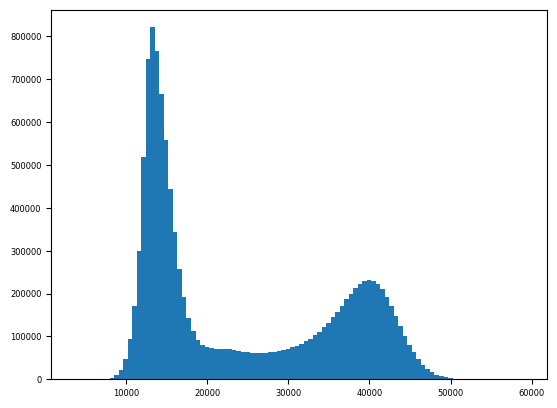

In [74]:
plt.hist(slices_02_t002.flatten(), bins=100)

plt.show()

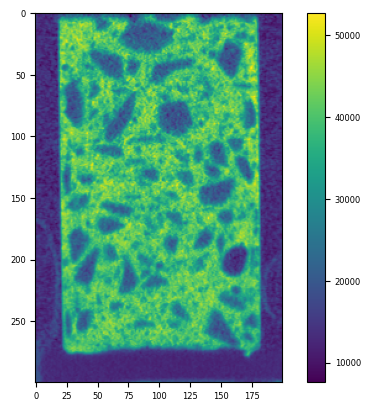

In [65]:
plt.imshow(slices_02_t002[:, 100].astype('uint16'))

plt.colorbar()

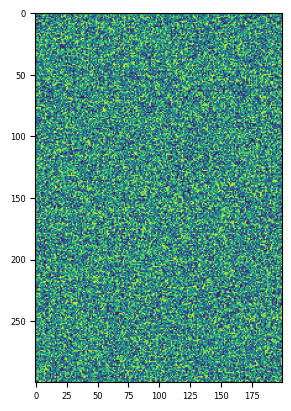

In [64]:
plt.imshow(slices_02_t002[:, 100].astype('uint8'))

In [75]:
slices_02_t002_scaled = (slices_02_t002 - slices_02_t002.min()) / (slices_02_t002.max() - slices_02_t002.min())

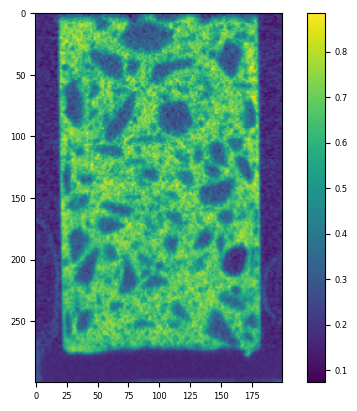

In [76]:
plt.imshow(slices_02_t002_scaled[:, 100])

plt.colorbar()

In [98]:
slices_02_t002_scaled_float_16 = slices_02_t002_scaled.astype('float16')
slices_02_t002_scaled_float_32 = slices_02_t002_scaled.astype('float32')

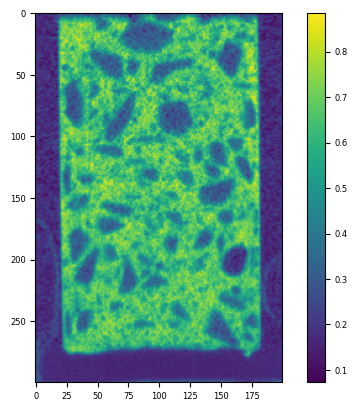

In [99]:
plt.imshow(slices_02_t002_scaled_float_16[:, 100])

plt.colorbar()

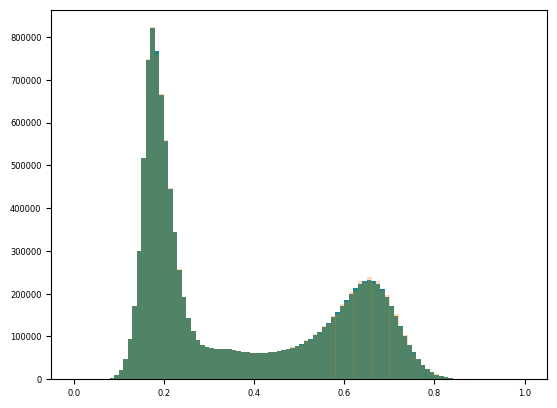

In [100]:
plt.hist(slices_02_t002_scaled.flatten(), bins=100)
plt.hist(slices_02_t002_scaled_float_16.flatten(), bins=100, alpha=0.3)
plt.hist(slices_02_t002_scaled_float_32.flatten(), bins=100, alpha=0.3)

plt.show()

In [102]:
np.save('./slices_02_t002_scaled_float_32.npy', slices_02_t002_scaled_float_32)
np.save('./slices_02_t002_scaled_float_16.npy', slices_02_t002_scaled_float_16)
np.save('./slices_02_t002.npy', slices_02_t002)

In [107]:
slices_02_t002 = np.load('./slices_02_t002.npy')

# Thrsholding

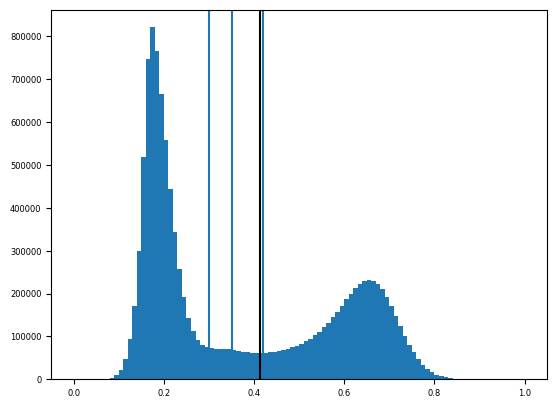

In [127]:
plt.hist(slices_02_t002_scaled.flatten(), bins=100)

threshold_0 = 0.3
plt.axvline(threshold_0)
threshold_1 = 0.35
plt.axvline(threshold_1)
threshold_2 = 0.42
plt.axvline(threshold_2)
threshold_otsu_value = threshold_otsu(slices_02_t002_scaled)
plt.axvline(threshold_otsu_value, color='k')
plt.show()

In [128]:
from skimage.filters import try_all_threshold

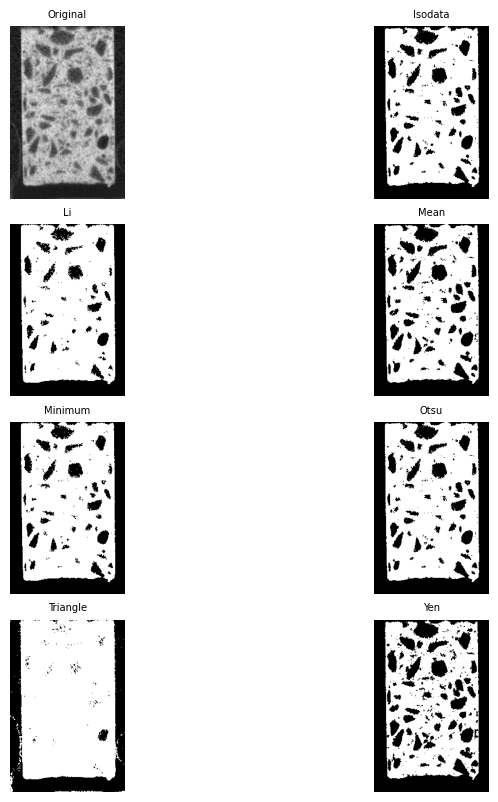

In [129]:
fig, ax = try_all_threshold(slices_02_t002_scaled[:, 100], figsize=(10, 8), verbose=False)
plt.show()

In [130]:
from skimage.filters import threshold_otsu, threshold_yen

In [131]:
threshold_otsu(slices_02_t002_scaled), threshold_yen(slices_02_t002_scaled)

/home/murilo/anaconda3/envs/spam/lib/python3.7/site-packages/skimage/filters/thresholding.py:441: RuntimeWarning: divide by zero encountered in log
  (P1[:-1] * (1.0 - P1[:-1])) ** 2)


(0.412109375, 0.318359375)

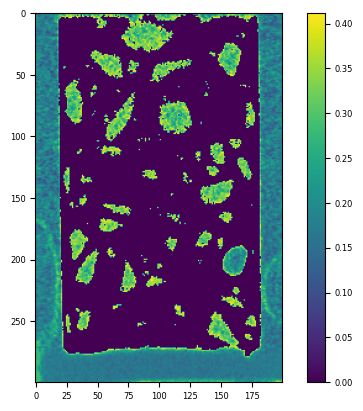

In [139]:
mask = (slices_02_t002_scaled < threshold_otsu_value)
plt.imshow((slices_02_t002_scaled * mask)[:, 100])

plt.colorbar()

# Segmentation

## Cropping the sample

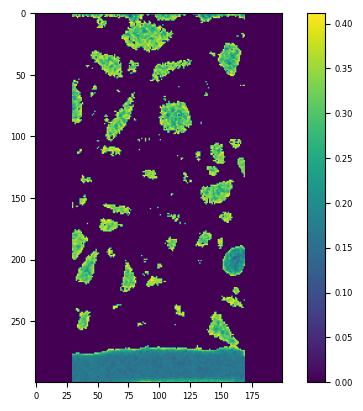

In [179]:
cylinder_mask = spam.mesh.createCylindricalMask(slices_02_t002_scaled.shape, 70, centre=[100, 100])
sample = cylinder_mask * slices_02_t002_scaled

plt.imshow((sample * mask)[:, 100])

plt.colorbar()

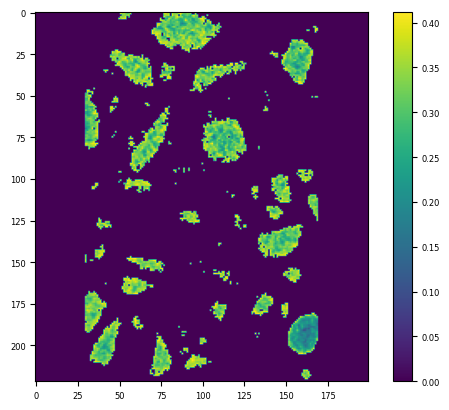

In [180]:
sample_only = (sample * mask)[8:230]
plt.imshow(sample_only[:, 100])

plt.colorbar()

In [181]:
sample_only[sample_only!=0] = 1

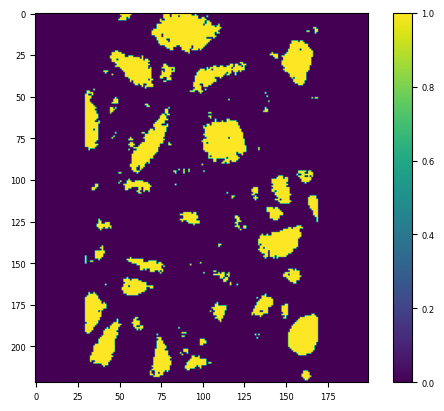

In [182]:
plt.imshow(sample_only[:, 100])

plt.colorbar()

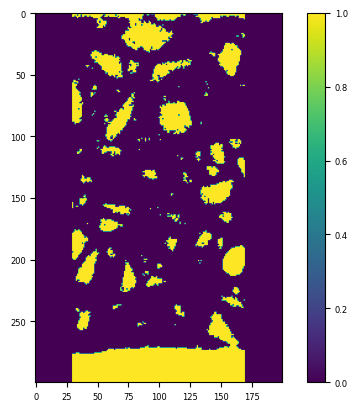

In [183]:
plt.imshow((mask * cylinder_mask)[:, 100])

plt.colorbar()

## Segmentation

In [184]:
labelled = spam.label.watershed(sample_only) 

In [203]:
# numpy method to obtain aggregte volumes
labels, label_sizes = np.unique(labelled, return_counts=True)
label_sizes_ignoring_0 = label_sizes[labels!=0]


# spam method to obtain aggregate volumes
spam_volumes = spam.label.volumes(labelled)

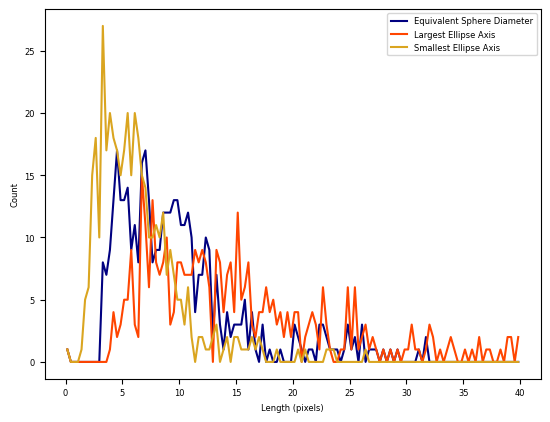

In [212]:
radii = spam.label.equivalentRadii(labelled)
ellipseAxes = spam.label.ellipseAxes(labelled)

import numpy

radiiHist = numpy.histogram(radii, range=[0, 20], bins=128)
ellipseBig = numpy.histogram(ellipseAxes[:, 0], range=[0, 20], bins=128)
ellipseSmall = numpy.histogram(ellipseAxes[:, 2], range=[0, 20], bins=128)

# compute correct x-axis positions including half-bin width
xRange = radiiHist[1][0:-1]+0.5*(radiiHist[1][1]-radiiHist[1][0])

# Multiply range by 2 in order to get diameters from radii
plt.plot(2*xRange, radiiHist[0],    label="Equivalent Sphere Diameter", color='navy')
plt.plot(2*xRange, ellipseBig[0],   label="Largest Ellipse Axis", color='orangered')
plt.plot(2*xRange, ellipseSmall[0], label="Smallest Ellipse Axis", color='goldenrod')
plt.xlabel("Length (pixels)")
plt.ylabel("Count")
plt.legend()
plt.show()

	plotParticleSizeDistribution(): Multiplying radii by two to make diameters


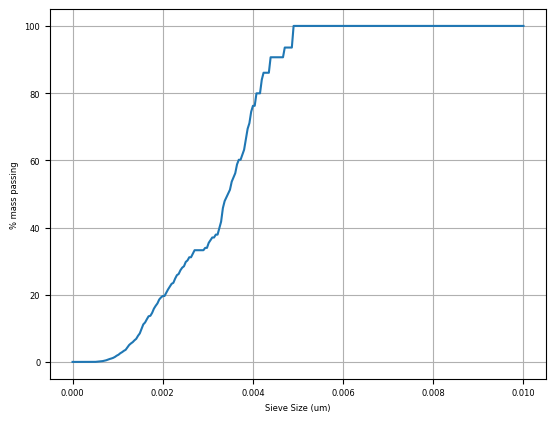

In [240]:
import spam.plotting

spam.plotting.plotParticleSizeDistribution(radii*160e-6, # Multiplying by pixel size in mm
                                           bins=256,
                                           units="um",
                                           cumulative=True,
                                           cumulativePassing=True,
                                           mode="mass", # % passing by mass and not number of particles
                                           range=[0, 0.01],
                                           logScaleX=False,
                                           logScaleY=False)

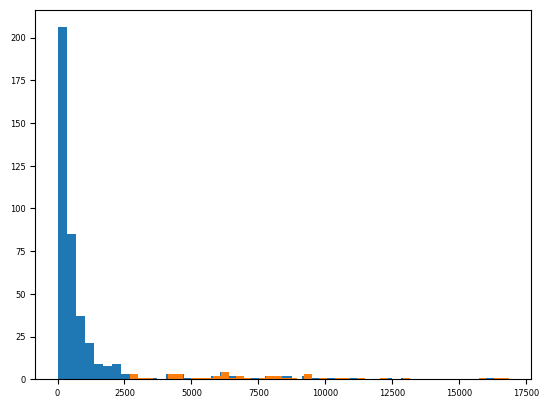

In [210]:
plt.hist(label_sizes_ignoring_0, bins=50)
plt.hist(label_sizes_ignoring_0[label_sizes_ignoring_0>2500], bins=50)

plt.show()

In [198]:
label_sizes_ignoring_0[np.argmax(label_sizes_ignoring_0)]

16864

In [185]:
(labelled==10).sum(axis=0).max(), (labelled==10).sum(axis=1).max(), (labelled==10).sum(axis=2).max()

(4, 7, 9)

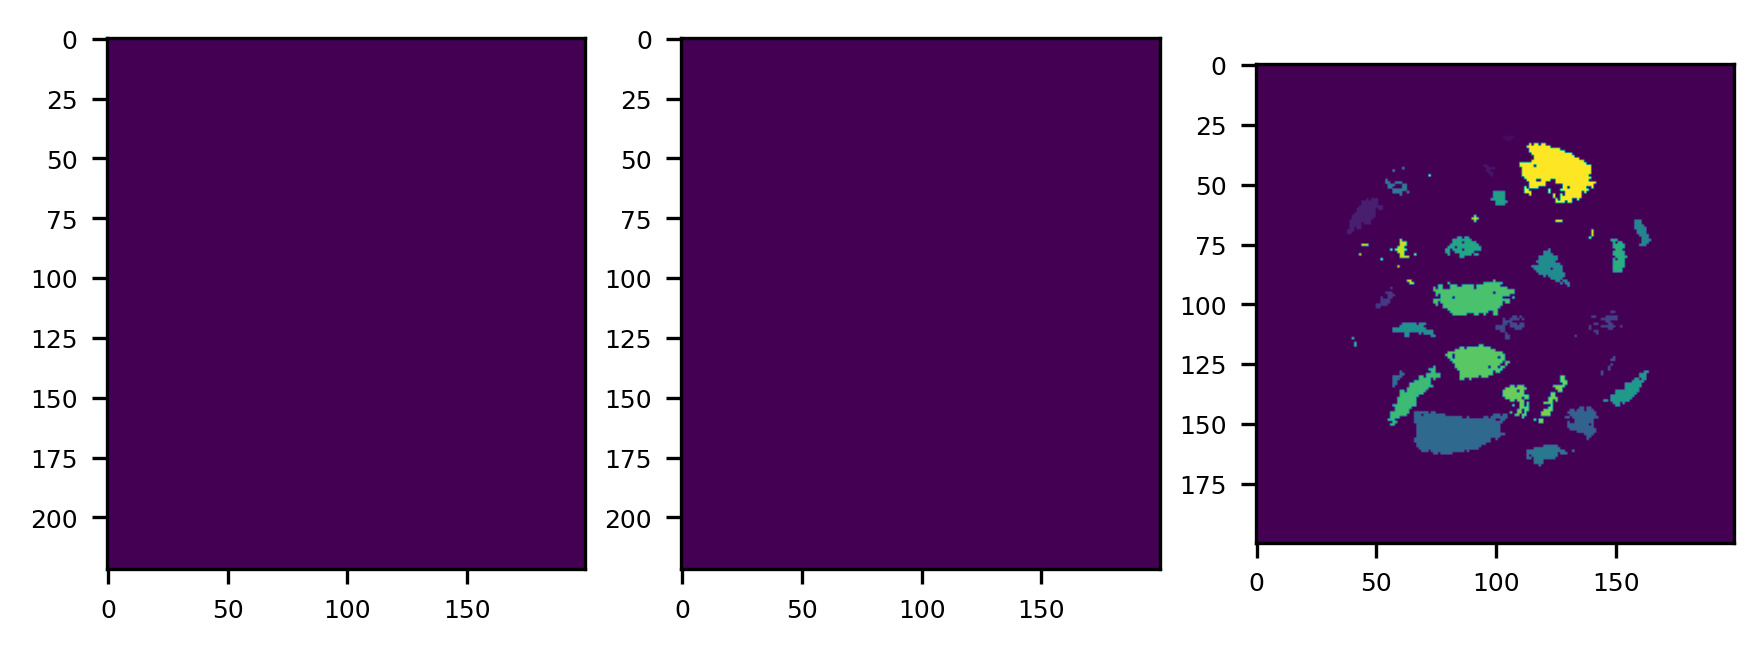

In [188]:
fig, axs = plt.subplots(1, 3, figsize=(7, 4), dpi=300)

im1 = axs[0].imshow(labelled[:, :, 9])
im2 = axs[1].imshow(labelled[:, 7, :])
im3 = axs[2].imshow(labelled[4, :, :])
plt.show()

In [241]:
display(labelled)

interactive(children=(IntSlider(value=100, continuous_update=False, description='x', max=200), IntSlider(value…